# NN1

This feed-forward neural network has a unique hidden layer with 350 neurons.

First, we load the packages.


In [2]:
import pandas as pd
import numpy as np
from PIL import Image    
from sklearn.utils import shuffle
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

Then, we divide the data in train and validation (0.9 and 0.1). Also,we define the read function. We extract the 32x32 center of the image.

In [25]:

data = pd.read_csv("newdata.csv")
data =shuffle(data)
n = round((data.shape[0]-1)*0.9)

train = data[1:n]
val = data[n:]

def readimage(n_batch, n, X):
    batch = []
    for i in range(n):
        path = "train/" + X.iloc[i+n*n_batch]['id']+ ".tif"
        img = cv2.imread(path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[32:32+32, 32:32+32]
        batch.append(np.moveaxis(img, -1,0))
        
    return torch.tensor(np.array(batch)).float()

Hidden layer: 350 neurons.<br>
Activation function: Leaky_relu. <br>
Inizialization: Xavier-Uniform. <br>
Output: Sigmoid of unique value. <br>
Cost function: Binary Cross Entropy with logit loss. <br>
Batch size: 174.<br>
Epochs: 100. <br>
Size of input : 3072.

In [ ]:
n_n = 350
n_batch = 174
n_size = 3072
n_val = val.shape[0]
it = round(train.shape[0]/n_batch)
max_value = 255

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_size,n_n, bias=True)
        self.batch=nn.BatchNorm1d(n_n)
        self.fc2 = nn.Linear(n_n,1, bias=True)
        
    def forward(self, x):
        x = F.leaky_relu(self.batch(self.fc1(x)))
        x = self.fc2(x)
        return torch.sigmoid(x)
    
def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(1)
    
net=Net()
net.apply(init_weights)
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.8)
criterion = nn.BCELoss()


l=[]
val_loss=[]
for epoch in range(100):
    train=shuffle(train)
    z=0
    for i in range(it):
        data=readimage(i, n_batch, train)
        data = data/max_value
        data=np.reshape(data, (n_batch, n_size))
        data = torch.Tensor(data)
        target = torch.Tensor(train['label'][n_batch*i:n_batch*(i+1)].values)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out.view(n_batch,1), target.view(n_batch,1))
        loss.backward()
        optimizer.step()
        z += loss.item()
    l.append(z/it)
    
    #Validation error
    data = readimageval(0,n_val, val)
    data = data/max_value
    data = torch.Tensor(np.reshape(data, (n_val, n_size)))
    target = torch.Tensor(val['label'].values)
    data, target = Variable(data), Variable(target)
    with torch.no_grad(): # 1) As do not want to update G 
         net_out = net(data) 
    val_loss.append( criterion(net_out.view(n_val,1), target.view(n_val,1)).item())
    print(l[epoch], val_loss[epoch], epoch)

We plot the learning curve.

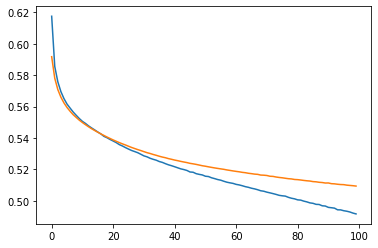

In [27]:
plt.plot(range(len(l)), l, range(len(l)), val_loss)

We plot the ROC curve.

AUC: 0.821
AUC NO SKILL: 0.500


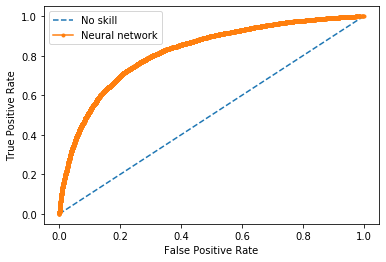

In [29]:


data=readimage(n_val )
data=data/max_value
data=np.reshape(data, (n_val ,n_size))
data = torch.Tensor(data.float())
target = val['label'].values
data=Variable(data)
with torch.no_grad(): # 1) As do not want to update G 
    net_out = torch.sigmoid(net(data) )
n_prob = [0 for _ in range(len(target))]


fpr1, tpr1, thresholds = roc_curve(target, net_out, pos_label = 1)
fpr2, tpr2, thresholds = roc_curve(target, n_prob, pos_label = 1)
auc1 = roc_auc_score(target, net_out)
auc2 = roc_auc_score(target, n_prob)
print('AUC: %.3f' % auc1)
print('AUC NO SKILL: %.3f' % auc2)
pyplot.plot(fpr2, tpr2, linestyle='--', label='No skill')
pyplot.plot(fpr1, tpr1, marker='.', label='Neural network')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()